In [1]:
import os, sys
# adjust this path if your repo is elsewhere
proj_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if proj_root not in sys.path:
    sys.path.append(proj_root)

# confirm device
import torch
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)
print(sys.executable)

Using device: cuda
/home/spieterman/dev/projects/dwi-transformer/.venv/bin/python


In [2]:
# Shape of each 3D volume (after your resampling step)
IMG_SHAPE = (91, 109, 91)

# Latent dimension for all AEs
LATENT_DIM = 256

# Training settings
BATCH_SIZE = 4
LR = 1e-5
EPOCHS = 50

# Paths
DATA_DIR = os.path.join(proj_root, "data", "encoder")
print("Data directory:", DATA_DIR)

Data directory: /home/spieterman/dev/projects/dwi-transformer/data/encoder


In [3]:
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import os
from collections import Counter
import nibabel as nib

RAW_DATA_DIR = "/home/spieterman/dev/projects/dwi-preprocessing/data/preproc/"

def find_nifti_files(root_dir):
    for dirpath, _, filenames in os.walk(root_dir):
        for fn in filenames:
            if fn.endswith((".nii.gz")):
                yield os.path.join(dirpath, fn)

shape_counts = Counter()
errors = []

for path in find_nifti_files(RAW_DATA_DIR):
    try:
        img = nib.load(path)
        shape_counts[img.shape] += 1
    except Exception as e:
        errors.append((path, str(e)))

# Display results
print("Unique volume shapes found:")
for shape, count in shape_counts.items():
    print(f"{shape}: {count} file{'s' if count>1 else ''}")

if errors:
    print(f"\n  {len(errors)} file(s) failed to load:")
    for p, err in errors[:5]:
        print(f"    - {p}: {err}")
    if len(errors)>5:
        print(f"    ... and {len(errors)-5} more")


Unique volume shapes found:
(91, 109, 91, 26): 151 files
(91, 109, 91): 239 files
(91, 109, 91, 91): 61 files
(91, 109, 91, 65): 9 files
(91, 109, 91, 13): 5 files
(91, 109, 91, 52): 1 file
(91, 109, 91, 69): 2 files
(91, 109, 91, 2): 8 files
(91, 109, 91, 50): 1 file
(91, 109, 91, 48): 1 file


In [5]:
from pathlib import Path
import numpy as np, nibabel as nib, json, argparse
from tqdm import tqdm

ROOT   = Path("/home/spieterman/dev/projects/dwi-preprocessing/data/preproc")
CACHE  = Path("/home/spieterman/dev/projects/dwi-transformer/data/encoder")                                       # output root
CACHE.mkdir(exist_ok=True)

def find_sessions(root: Path):
    return sorted(root.rglob("*_dwi_allruns.nii.gz"))

def normalise_dwi(dwi_data: np.ndarray, bvals: np.ndarray):
    """
    Load a 4-D DWI series and apply robust, session-level gain and z-score normalisation.

    Parameters
    ----------
    dwi_path : Path
        Path to the cleaned 4-D DWI NIfTI (shape [X,Y,Z,N]).
    bval_path : Path
        Path to the matching .bval file (one row of N b-values).

    Returns
    -------
    dwi_norm : ndarray (float32)
        The fully normalised DWI data (same shape as input).
    stats : dict
        {
          'gain': float,       # scale factor applied to align b0 median → 1.0
          'mean': float,       # session-wide mean after gain scaling
          'std':  float        # session-wide std  after gain scaling
        }
    """

    # 1) Identify all b0 volumes (b-value == 0)
    b0_indices  = np.where(bvals == 0)[0]         # e.g. array([0, 10, 20])

    # 2) Extract those b0 volumes and form a union-mask of nonzero voxels
    #    (handles slight mis-alignments: if *any* run has signal, we treat it as brain)
    b0_volumes = np.take(dwi_data, b0_indices, axis=3)  # shape (X, Y, Z, N_b0)
    mask       = np.any(b0_volumes > 0, axis=3)         # boolean mask [X,Y,Z]

    # 3) Remove any stray zero-intensity voxels inside the union mask
    #    (e.g. holes due to warping) before computing the gain
    b0_values  = b0_volumes[mask].ravel()
    b0_values  = b0_values[b0_values > 0]               # drop zeros

    # 4) SESSION-GAIN NORMALISATION:
    #    Anchor the median of all b0 tissue intensities to 1.0,
    #    removing scanner-/coil-level scale differences across sessions
    gain       = 1.0 / (np.median(b0_values) + 1e-12)
    dwi_scaled = dwi_data * gain

    # 5) SESSION-WIDE Z-SCORE NORMALISATION:
    #    Compute mean/std across all brain voxels in all volumes,
    #    giving zero-mean/unit-variance inputs for the autoencoder,
    #    yet preserving relative shell attenuation patterns.
    dwi_values = dwi_scaled[mask, ...].ravel()
    dwi_values = dwi_values[dwi_values > 0]              # drop any sneaky zeros
    mean       = dwi_values.mean()
    std        = dwi_values.std() + 1e-6
    dwi_norm   = (dwi_scaled - mean) / std

    # 6) Return the normalised data plus the stats for reproducibility
    return dwi_norm.astype(np.float32)


def process_session(dwi_path: Path):
    """
    Process a single 4-D DWI session and cache its 3-D gradient volumes.

    Parameters
    ----------
    dwi_path : pathlib.Path
        Path to the cleaned 4-D DWI NIfTI file (shape [X, Y, Z, N]).

    Steps
    -----
    1) Derive the matching .bval and .bvec file paths.
    2) Parse patient ID (sub-XXX) and session ID (ses-YYY) from the filename.
    3) Create an output directory at CACHE/sub-XXX/ses-YYY/.
    4) Load the raw 4-D DWI data and corresponding b-values.
    5) Load the .bval file containing the b-values for each gradient.
    6) Normalize the entire volume (session-level gain + z-score).
    7) Split the normalized 4-D volume into N individual 3-D gradient arrays and save each gradient as a compressed .npz containing:
        - vol_data: 3-D image array
        - bval: single float b-value
        - bvec: 3-D b-vector (if available, currently not used)
        - affine: 4 x 4 spatial transform
        - patient, session tags
    """

    # 1) Derive file stems for .bval and .bvec
    #    We strip off the trailing ".nii.gz" by slicing off 7 chars
    base      = dwi_path.with_suffix("").with_suffix("")  # remove .nii.gz (with_suffix only removes one suffix at a time)
    bval_path = base.with_suffix(".bval")
    bvec_path = base.with_suffix(".bvec")

    # 2) Extract patient & session IDs from the BIDS-style filename
    #    Filename looks like "sub-XXX_ses-YYY_dwi_allruns.nii.gz"
    p_id = base.name.split("_")[0]  # e.g. "sub-0001"
    s_id = base.name.split("_")[1]  # e.g. "ses-01"

    # 3) Prepare the output folder for this session
    #    e.g. cache/sub-0001_ses-01/
    out_dir = CACHE / p_id / s_id
    out_dir.mkdir(parents=True, exist_ok=True)

    # 4) Load the 4-D DWI image (keeps affine + header for later)
    dwi_img = nib.load(dwi_path)                             # nibabel Nifti1Image
    dwi_raw = dwi_img.get_fdata().astype(np.float32)         # (X, Y, Z, N)

    # 5) Load acquisition metadata
    #    .bval: one row of N diffusion weightings
    #    .bvec: 3×N axis vectors
    bvals = np.loadtxt(bval_path)                            # shape (N,)
    # bvecs = np.loadtxt(bvec_path)                            # shape (3, N)

    # 6) Normalize the 4-D data with our robust session-level function
    #    Returns the normalized array
    dwi_norm = normalise_dwi(dwi_raw, bvals)

    # 7) Split the normalized 4-D volume into individual 3-D gradient volumes
    #    and save each as a compressed .npz with all relevant metadata.
    for g in range(dwi_norm.shape[3]):
        vol_data = dwi_norm[..., g]  # 3-D array (X, Y, Z)

        out_file = out_dir / f"{p_id}_{s_id}_grad{g:03d}.npz"
        np.savez_compressed(
            out_file,
            vol_data=vol_data,                          # 3D gradient volume (X, Y, Z)
            bval=np.float32(bvals[g]),                  # single b-value for this gradient
            # bvec=np.float32(bvecs[:, g]),             # 3D b-vector for this gradient TODO: bvecs are wrongly concatenated over runs
            affine=dwi_img.affine.astype(np.float32),   # preserves spatial orientation for nifti reconstruction
            patient=p_id,                               # for downstream grouping or sampling
            session=s_id                                # ditto
        )


# # if __name__ == "__main__":
# for dwi_file in tqdm(find_sessions(Path(ROOT))):
#     process_session(dwi_file)


In [6]:
from torch.utils.data import Dataset

class AEVolumes(Dataset):
    def __init__(self, cache_root: str):
        # 1) Find all cached gradient files
        self.files = sorted(Path(cache_root).rglob("*grad*.npz"))

        # 2) Preload metadata for sampling weights
        self.patients = []
        self.sessions = []
        self.bvals    = []
        for f in self.files:
            data = np.load(f)
            # Extract scalar metadata
            self.patients.append(data["patient"].item())  # e.g. "sub-0001"
            self.sessions.append(data["session"].item())  # e.g. "ses-01"
            self.bvals.append(float(data["bval"].item()))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        # 1) Load the .npz
        data = np.load(self.files[idx])

        # 2) Volume: [1, X, Y, Z]
        vol = torch.from_numpy(data["vol_data"]).unsqueeze(0).float()

        # 3) Acquisition metadata
        bval = torch.tensor(float(data["bval"].item()), dtype=torch.float32)
        # bvec = torch.from_numpy(data["bvec"].astype(np.float32))

        # 4) Spatial metadata
        affine = torch.from_numpy(data["affine"].astype(np.float32))  # [4, 4]

        # 5) Patient tags
        patient = data["patient"].item()  # string
        session = data["session"].item()  # string

        return {
            "vol":     vol,
            "bval":    bval,
            # "bvec":    bvec,
            "affine":  affine,
            "patient": patient,
            "session": session,
        }

In [7]:
from collections import Counter, defaultdict
from torch.utils.data import WeightedRandomSampler

def make_balanced_sampler(
    dataset, alpha=0.3
):
    """
    Build a sampler that up-weights rare shells but still lets b=1000
    be seen fairly often. We use w_shell[b] = 1 / (k_b ** alpha).
    """

    # 1) Count how many sessions per patient
    patient2sessions = defaultdict(set)
    for p, s in zip(dataset.patients, dataset.sessions):
        patient2sessions[p].add(s)
    S_counts = {p: len(sset) for p, sset in patient2sessions.items()} # |S_p| for each patient p
    # e.g. {'sub-0001': 3, 'sub-0002': 2, ...} where 3 means 3 sessions for that patient

    # 2) Count how many volumes in each (patient,session)
    sess_keys   = list(zip(dataset.patients, dataset.sessions))
    V_cnt = Counter(sess_keys)    # |V_{p,s}| for each (patient, session) pair
    # e.g. {('sub-OAS30001', 'ses-d0757'): 26, ('sub-OAS30001', 'ses-d1234'): 120, ...}

    # 3) Count how many volumes in each shell
    shell_cnt = Counter(dataset.bvals)  # N_b for each b-value
    # e.g. {0: 300, 500: 320, 1000: 4500, ...}

    # 4) Build the “power‐law” shell weights
    #    Smaller alpha -> less flattening; alpha=1 -> full flattening; alpha=0 -> no flatten.
    w_shell = {b: 1.0 / (shell_cnt[b] ** alpha) for b in shell_cnt}

    # 5) Build the final weights for each sample
    weights = []
    for (p, s, b) in zip(dataset.patients, dataset.sessions, dataset.bvals):
        w  = 1.0 / S_counts[p]                  # patient factor
        w *= 1.0 / V_cnt[(p, s)]                # session factor
        w *= 1.0 / (shell_cnt[b] ** alpha)      # tempered shell factor
        w *= 10                                 # boost the weights to make them more pronounced
        weights.append(w)

    # 6) Create the PyTorch sampler
    sampler = WeightedRandomSampler(
        weights=torch.DoubleTensor(weights),
        num_samples=len(weights),
        replacement=True
    )
    return sampler

10431 volumes found in cache


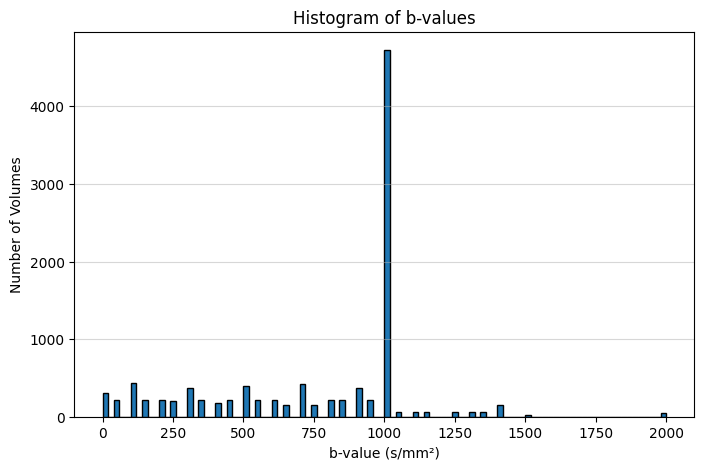

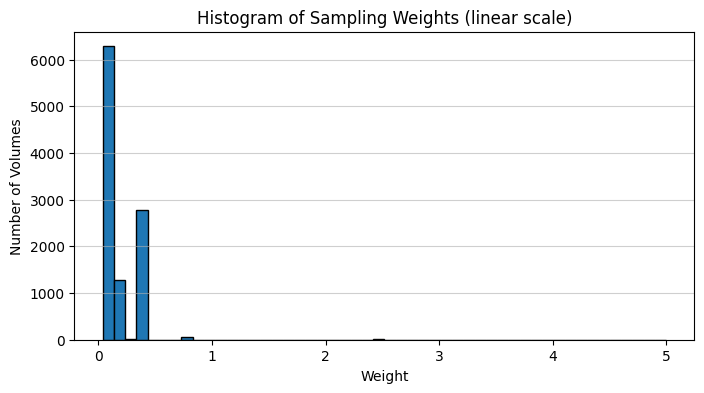

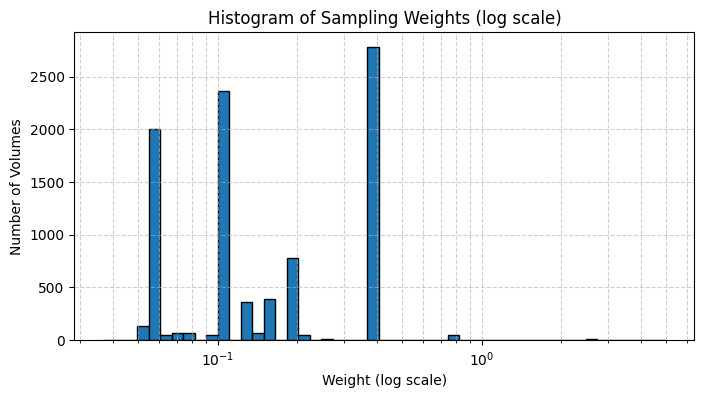

 Min weight: 0.0366, Max weight: 5.0000, Mean weight: 0.1793


In [8]:
import matplotlib.pyplot as plt
import numpy as np

CACHE  = Path("/home/spieterman/dev/projects/dwi-transformer/data/encoder") 
dataset = AEVolumes(cache_root=str(CACHE))
print(len(dataset), "volumes found in cache")
# Suppose `bvals` is your existing Python list or NumPy array of b-values:
# bvals = [0, 1000, 1000, 2000, 0, 1500, 3000, …]

# If it’s a Python list, convert to a NumPy array:
bvals = np.array(dataset.bvals)

# Plot the histogram
plt.figure(figsize=(8, 5))
plt.hist(bvals, bins=100, edgecolor="black")
plt.title("Histogram of b-values")
plt.xlabel("b-value (s/mm²)")
plt.ylabel("Number of Volumes")
plt.grid(axis="y", alpha=0.5)
plt.show()

# Create the dataset and sampler
sampler = make_balanced_sampler(dataset, alpha=0.0)

# 2a) plot the distribution of weights
weights = [w for w in sampler.weights]
plt.figure(figsize=(8, 4))
plt.hist(weights, bins=50, edgecolor="black")
plt.title("Histogram of Sampling Weights (linear scale)")
plt.xlabel("Weight")
plt.ylabel("Number of Volumes")
plt.grid(axis="y", alpha=0.6)
plt.show()

# 2b) Log‐scale histogram (bins spaced logarithmically)
log_bins = np.logspace(np.log10(min(weights)+1e-8), np.log10(max(weights)), 50)
plt.figure(figsize=(8, 4))
plt.hist(weights, bins=log_bins, edgecolor="black")
plt.xscale("log")
plt.title("Histogram of Sampling Weights (log scale)")
plt.xlabel("Weight (log scale)")
plt.ylabel("Number of Volumes")
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.show()

print(f" Min weight: {min(weights):.4f}, Max weight: {max(weights):.4f}, Mean weight: {np.mean(weights):.4f}")

In [9]:
from models.auto_encoders import SlimAutoencoder

import gc
import torch

torch.cuda.empty_cache()  # releases unoccupied cached memory
gc.collect()              # collects Python garbage

x = torch.randn(1, 1, *IMG_SHAPE).to(DEVICE)  # Example input tensor with shape [1, 1, 91, 109, 91]

model = SlimAutoencoder(z_dim=LATENT_DIM).to(DEVICE)

out = model(x)

print(out.shape)  # Should be [1, 1, 91, 109, 91] if the output shape matches input shape

torch.Size([1, 1, 91, 109, 91])


In [10]:
for b in [2, 4, 8, 16, 32, 64]:
    try:
        loader = DataLoader(
            dataset,
            batch_size=b,
            sampler=sampler,
            num_workers=8,
            pin_memory=True
        )
        # Run one forward and backward pass:
        vol = next(iter(loader))["vol"].to(DEVICE)
        with torch.no_grad():
            _ = model(vol)
        print(f"batch_size={b} fits")
    except RuntimeError as e:
        if "out of memory" in str(e):
            print(f"batch_size={b} -> OOM")
            break
        else:
            raise

# Clean up memory
torch.cuda.empty_cache()  # releases unoccupied cached memory
gc.collect()              # collects Python garbage
del model  # or any other large tensor/model

batch_size=2 fits
batch_size=4 fits
batch_size=8 fits
batch_size=16 fits
batch_size=32 -> OOM


In [11]:
from torch.utils.data import Subset
import numpy as np
import torch


def create_val_test_split(
        dataset,
        val_fraction: float = 0.1,
        seed: int = 42
):
    """
    Randomly split `dataset` into train / val subsets **and**
    attach `.patients`  and `.sessions` lists that correspond
    only to the samples inside each subset.

    Returns
    -------
    train_subset : torch.utils.data.Subset
    val_subset   : torch.utils.data.Subset
    """
    n_total = len(dataset)
    n_val   = int(np.floor(val_fraction * n_total))

    # deterministic shuffle
    rng      = np.random.default_rng(seed)
    all_idx  = np.arange(n_total)
    rng.shuffle(all_idx)

    val_idx   = all_idx[:n_val]
    train_idx = all_idx[n_val:]

    def make_subset(idxs):
        sub = Subset(dataset, idxs.tolist())
        # attach split-specific metadata for later weighting
        sub.patients  = [dataset.patients[i]  for i in idxs]
        sub.sessions  = [dataset.sessions[i]  for i in idxs]
        sub.bvals     = [dataset.bvals[i]     for i in idxs]

        return sub

    return make_subset(train_idx), make_subset(val_idx)


In [12]:
val_fraction = 0.1
val_size = int(len(dataset) * val_fraction)
train_size = len(dataset) - val_size

# reproducible split
generator = torch.Generator().manual_seed(42)
train_ds, val_ds = create_val_test_split(
    dataset,
    val_fraction=val_fraction,
    seed=42
)

# Create balanced samplers for training and validation datasets
train_sampler = make_balanced_sampler(train_ds, alpha=0.0)  # Use alpha=0.0 for no flattening
val_sampler = make_balanced_sampler(val_ds, alpha=0.0)    # Use alpha=0.0 for no flattening

# Create the DataLoaders for training and validation
train_loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    sampler=train_sampler,
    num_workers=8,
    pin_memory=True
)
val_loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    sampler=val_sampler,
    num_workers=8,
    pin_memory=True
)

In [ ]:
from tqdm import tqdm

def run_epoch(model, loader, criterion, optimiser=None):
    """
    Train if `optimizer` is given, otherwise just validate.
    Returns the average loss for the epoch.
    """
    is_train = optimiser is not None
    model.train(mode=is_train)
    running_loss, n_batches = 0.0, 0

    print("Mode:", "Train" if is_train else "Eval")
    print("Using", DEVICE)
    print(f"Batch size: {loader.batch_size}, Batches: {len(loader)}, Samples: {len(loader.dataset)}")
    print(f"Patients: {len(set(loader.dataset.patients))}, Sessions: {len(set(loader.dataset.sessions))}")

    context = torch.enable_grad() if is_train else torch.no_grad()
    with context:
        for entry in tqdm(loader):
            x = entry["vol"].to(DEVICE, dtype=torch.float32, non_blocking=True)

            # Forward
            recon = model(x)
            loss = criterion(recon, x)

            if is_train:
                optimiser.zero_grad(set_to_none=True)
                loss.backward()
                optimiser.step()

            running_loss += loss.item()
            n_batches += 1

    return running_loss / n_batches

In [14]:
import pandas as pd

# Clean up memory
torch.cuda.empty_cache()
gc.collect()

chkpt_path = Path("/home/spieterman/dev/projects/dwi-transformer/checkpoints/best_ae.pt")
patience   = 3          # epochs with no val-improvement before stop
best_val   = np.inf
pat_wait   = 0

model = SlimAutoencoder(z_dim=LATENT_DIM).to(DEVICE)
optimiser = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.MSELoss()

history = {"epoch": [], "train_loss": [], "val_loss": []}

for epoch in range(1, EPOCHS + 1):
    train_loss = run_epoch(model, train_loader, criterion, optimiser)
    
    torch.cuda.empty_cache()  # <- keep this to prevent OOM
    val_loss = run_epoch(model, val_loader, criterion)

    history["epoch"].append(epoch)
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)

    print(f"Epoch {epoch:02d} | train {train_loss:.4e} | val {val_loss:.4e}")

    # Early stopping
    if val_loss < best_val - 1e-6:                 # small epsilon to avoid tiny fluctuations
        best_val = val_loss
        pat_wait = 0
        torch.save({"epoch": epoch,
                    "model_state": model.state_dict(),
                    "optim_state": optimiser.state_dict(),
                    "val_loss": best_val},
                   chkpt_path)
        print(f"New best model saved to {chkpt_path} (val={best_val:.4e})")
    else:
        pat_wait += 1
        print(f"no improvement ({pat_wait}/{patience})")

    if pat_wait >= patience:
        print("Early stopping triggered.")
        break

hist_df = pd.DataFrame(history)

Mode: Train
Using cuda
Batch size: 4, Batches: 2347, Samples: 10431
Patients: 187, Sessions: 218


100%|██████████| 2347/2347 [19:32<00:00,  2.00it/s]


Mode: Eval
Using cuda
Batch size: 4, Batches: 261, Samples: 10431
Patients: 187, Sessions: 218


100%|██████████| 261/261 [00:38<00:00,  6.73it/s]


Epoch 01 | train 3.4579e-01 | val 2.1792e-01
New best model saved to /home/spieterman/dev/projects/dwi-transformer/checkpoints/best_ae.pt (val=2.1792e-01)
Mode: Train
Using cuda
Batch size: 4, Batches: 2347, Samples: 10431
Patients: 187, Sessions: 218


100%|██████████| 2347/2347 [19:30<00:00,  2.00it/s]


Mode: Eval
Using cuda
Batch size: 4, Batches: 261, Samples: 10431
Patients: 187, Sessions: 218


100%|██████████| 261/261 [00:38<00:00,  6.73it/s]


Epoch 02 | train 1.4210e-01 | val 1.3553e-01
New best model saved to /home/spieterman/dev/projects/dwi-transformer/checkpoints/best_ae.pt (val=1.3553e-01)
Mode: Train
Using cuda
Batch size: 4, Batches: 2347, Samples: 10431
Patients: 187, Sessions: 218


100%|██████████| 2347/2347 [19:36<00:00,  2.00it/s]


Mode: Eval
Using cuda
Batch size: 4, Batches: 261, Samples: 10431
Patients: 187, Sessions: 218


100%|██████████| 261/261 [00:38<00:00,  6.70it/s]


Epoch 03 | train 1.1663e-01 | val 1.2187e-01
New best model saved to /home/spieterman/dev/projects/dwi-transformer/checkpoints/best_ae.pt (val=1.2187e-01)
Mode: Train
Using cuda
Batch size: 4, Batches: 2347, Samples: 10431
Patients: 187, Sessions: 218


100%|██████████| 2347/2347 [19:34<00:00,  2.00it/s]


Mode: Eval
Using cuda
Batch size: 4, Batches: 261, Samples: 10431
Patients: 187, Sessions: 218


100%|██████████| 261/261 [00:38<00:00,  6.72it/s]


Epoch 04 | train 1.0697e-01 | val 1.2320e-01
no improvement (1/3)
Mode: Train
Using cuda
Batch size: 4, Batches: 2347, Samples: 10431
Patients: 187, Sessions: 218


100%|██████████| 2347/2347 [19:34<00:00,  2.00it/s]


Mode: Eval
Using cuda
Batch size: 4, Batches: 261, Samples: 10431
Patients: 187, Sessions: 218


100%|██████████| 261/261 [00:38<00:00,  6.71it/s]


Epoch 05 | train 1.0498e-01 | val 1.0866e-01
New best model saved to /home/spieterman/dev/projects/dwi-transformer/checkpoints/best_ae.pt (val=1.0866e-01)
Mode: Train
Using cuda
Batch size: 4, Batches: 2347, Samples: 10431
Patients: 187, Sessions: 218


100%|██████████| 2347/2347 [19:34<00:00,  2.00it/s]


Mode: Eval
Using cuda
Batch size: 4, Batches: 261, Samples: 10431
Patients: 187, Sessions: 218


100%|██████████| 261/261 [00:38<00:00,  6.74it/s]


Epoch 06 | train 1.0183e-01 | val 1.3241e-01
no improvement (1/3)
Mode: Train
Using cuda
Batch size: 4, Batches: 2347, Samples: 10431
Patients: 187, Sessions: 218


100%|██████████| 2347/2347 [19:27<00:00,  2.01it/s]


Mode: Eval
Using cuda
Batch size: 4, Batches: 261, Samples: 10431
Patients: 187, Sessions: 218


100%|██████████| 261/261 [00:38<00:00,  6.71it/s]


Epoch 07 | train 1.0065e-01 | val 1.0806e-01
New best model saved to /home/spieterman/dev/projects/dwi-transformer/checkpoints/best_ae.pt (val=1.0806e-01)
Mode: Train
Using cuda
Batch size: 4, Batches: 2347, Samples: 10431
Patients: 187, Sessions: 218


100%|██████████| 2347/2347 [19:29<00:00,  2.01it/s]


Mode: Eval
Using cuda
Batch size: 4, Batches: 261, Samples: 10431
Patients: 187, Sessions: 218


100%|██████████| 261/261 [00:38<00:00,  6.71it/s]


Epoch 08 | train 9.2498e-02 | val 1.1553e-01
no improvement (1/3)
Mode: Train
Using cuda
Batch size: 4, Batches: 2347, Samples: 10431
Patients: 187, Sessions: 218


  3%|▎         | 73/2347 [00:37<19:21,  1.96it/s]


KeyboardInterrupt: 

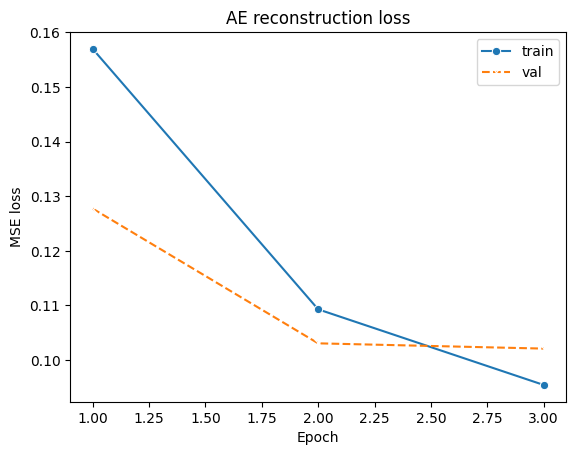

In [ ]:
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt

hist_df = pd.DataFrame(history)

sns.lineplot(data=hist_df, x="epoch", y="train_loss",
             marker="o", label="train")
sns.lineplot(data=hist_df, x="epoch", y="val_loss",
             marker="x", linestyle="--", label="val")
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.title("AE reconstruction loss")
plt.show()

Loaded best model from epoch 7  (val=1.0806e-01)


/tmp/ipykernel_3378/3059728171.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(chkpt_path, map_location=DEVICE)


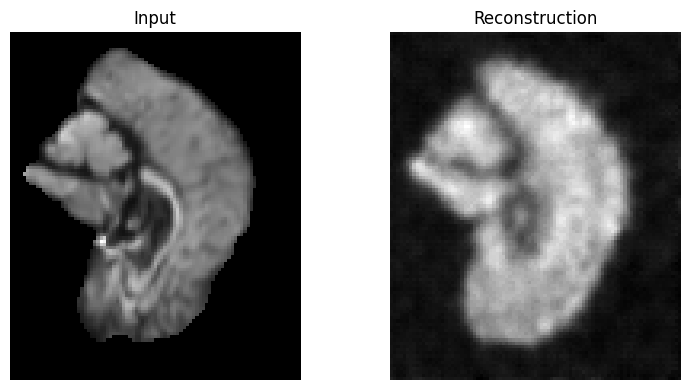

In [35]:
checkpoint = torch.load(chkpt_path, map_location=DEVICE)
model.load_state_dict(checkpoint["model_state"])
model.eval()
print(f"Loaded best model from epoch {checkpoint['epoch']}  (val={checkpoint['val_loss']:.4e})")

# fetch a single batch from validation loader
batch = next(iter(val_loader))

# depending on your collate_fn, batch may be a dict or tuple
if isinstance(batch, dict):
    vols = batch["vol"]                      # shape (B, 1, 91, 109, 91)
else:
    vols = batch[0]                          # dataset already yielded the tensor

sample = vols[:1].to(DEVICE)                 # keep one sample

with torch.no_grad():
    recon = model(sample)

# choose an axial slice halfway through the z-dimension
D, H, W = sample.shape[-3:]
mid_z = D // 2

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(sample.cpu()[0, 0, mid_z], cmap="gray")
ax[0].set_title("Input")
ax[0].axis("off")

ax[1].imshow(recon.cpu()[0, 0, mid_z], cmap="gray")
ax[1].set_title("Reconstruction")
ax[1].axis("off")

plt.tight_layout()
plt.show()